---
title: Projet 4
publishDate: 2020-03-04 00:00:00
img: /assets/stock-3.jpg
img_alt: Pearls of silky soft white cotton, bubble up under vibrant lighting
description: |
  We developed a virtual showcase for the softest bedding imaginable.
tags:
  - Design
  - Dev
  - Branding
---

<script>
MathJax = {
  	tex: {
    	inlineMath: [['$', '$'], ['\\(', '\\)']]
  	},
  	svg: {
    fontCache: 'global'
  	}
};
</script>


### 1. Introduction

<p style="text-align: justify;">
Dans cette unité d'enseignement, nous allons approfondir les connaissances techniques de la méthode des éléments finis. Pour cela, nous aborderons la résolution des systèmes non-linéaires et les problématiques liées. Cet apprentissage sera fait à travers une série de travaux pratiques où seront développés des codes EF en python/C++ à l'aide de la librairie FEniCS (librairie open-source), ceci donnant une approche informatique (High Performance Computing) de cet enseignement souvent appelée mécanique numérique.
</P> 

####  Python

<p style="text-align: justify;">
Python est un langage de programmation très largement utilisé dans les environnements académiques et industriels. Sa syntaxe est pour plusieurs aspects similaire à celle de Matlab.
</P> 

<p style="text-align: justify;">
À la différence de Matlab, Python est un logiciel libre. Un nombre croissant de librairies dédiées à la résolution de problèmes spécifiques (modules) est disponible librement. Deux modules sont indispensables pour les calculs scientifiques : matplotlib et numpy. Une large documentation et différents cours à tous les niveaux sont disponibles en ligne (cf Bibliographie).
</P> 

####  FEniCS

<p style="text-align: justify;">
FEniCS est un projet collaboratif développé par un groupe d'instituts de recherche à travers le monde. La librairie est distribuée gratuitement. FEniCS fournit une infrastructure avancée et moderne pour la résolution numérique des Équations aux Dérivées Partielles (EDP) par la méthode des éléments finis. Nous utiliserons l'interface Python de FEniCS, qui est chargée comme un module de Python à partir d'une console ou d'un script python, avec la commande :
</P> 

In [ ]:
from fenics import *

Tout problème d'éléments finis peut être construit de la manière suivante :

  1. Description de la géométrie, maillage. Choix du support géométrique.
  2. Choix du type d'éléments finis et du modèle de comportement.
  3. Données des caractéristiques du matériau et de la géométrie supplémentaire.
  4. Données des conditions aux limites.
  5. Données du chargement.
  6. Résolution du système.
  7. Post-traitement des résultats.

<p style="text-align: justify;">
L'objectif de ce premier TP est alors de résoudre avec FEniCS un problème de conduction thermique stationnaire (équation de Poisson).
</P> 

### 2. Prise en main de Fenics : Équation de Poisson

<p style="text-align: justify;">
Pour comprendre comment est structuré un script Python permettant la résolution d'un problème EDP à l'aide de FEniCS, nous allons suivre pas à pas l'exemple décrit dans le tutoriel du code, puis nous en inspirer pour résoudre un problème simple de thermique.
</P> 

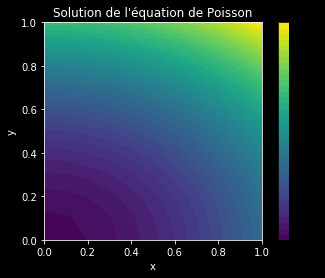

In [2]:
# Importation des modules nécessaires
import fenics as fe
import numpy as np
import matplotlib.pyplot as plt

# Génération du maillage
mesh = fe.UnitSquareMesh(10, 10)
# Définition de l'espace de fonction (P = Lagrange)
V = fe.FunctionSpace(mesh, 'P', 1)

# Formulation variationnelle
u_test = fe.TestFunction(V)
u_trial = fe.TrialFunction(V)
f = fe.Constant(-6.0)
a = fe.dot(fe.grad(u_test), fe.grad(u_trial)) * fe.dx
L = f * u_test * fe.dx
ubar = fe.Expression('1 + pow(x[0], 2) + 2 * pow(x[1], 2)', degree=2)

# Conditions aux limites
bc = fe.DirichletBC(V, ubar, fe.DomainBoundary())

# Assemblage de la matrice et du vecteur de force
A = fe.assemble(a)
b = fe.assemble(L)

# Imposition des conditions aux limites
bc.apply(A, b)

# Résolution du système linéaire
u = fe.Function(V)
fe.solve(A, u.vector(), b, "gmres", "ilu")

# Tracer la solution avec Matplotlib
plt.figure(facecolor='black')  # Fond noir
plt.gca().patch.set_facecolor('black')
plot = fe.plot(u)
plt.colorbar(plot)
plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['top'].set_color('white')
plt.gca().spines['right'].set_color('white')
plt.gca().spines['left'].set_color('white')
plt.gca().tick_params(axis='x', colors='white')
plt.gca().tick_params(axis='y', colors='white')
plt.xlabel('x', color='white')
plt.ylabel('y', color='white')
plt.title('Solution de l\'équation de Poisson', color='white')
plt.savefig('output/poisson_solution_plot.png', facecolor='black')  # Spécifier le chemin du fichier PNG
plt.show()

<div style="text-align: center;">
  <figure style="display: inline-block;">
    <img src="/src/content/work/output/poisson_solution_plot.png" alt="Figure 1 : Solution de l\'équation de Poisson" width="350"/>
    <figcaption>Figure 1 : Solution de léquation de Poisson </figcaption>
  </figure>
</div>

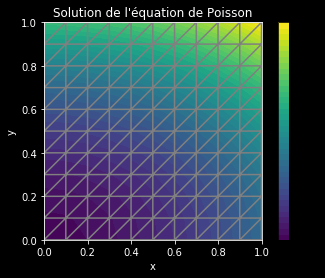

In [3]:
# Tracer la solution avec Matplotlib
plt.figure(facecolor='black')  # Fond noir
plt.gca().patch.set_facecolor('black')
plot = fe.plot(u)
plt.colorbar(plot)
plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['top'].set_color('white')
plt.gca().spines['right'].set_color('white')
plt.gca().spines['left'].set_color('white')
plt.gca().tick_params(axis='x', colors='white')
plt.gca().tick_params(axis='y', colors='white')
plt.xlabel('x', color='white')
plt.ylabel('y', color='white')
plt.title('Solution de l\'équation de Poisson', color='white')
fe.plot(mesh)
plt.savefig('output/poisson_solution_plot_mesh.png', facecolor='black')  # Spécifier le chemin du fichier PNG
plt.show()

<div style="text-align: center;">
  <figure style="display: inline-block;">
    <img src="/src/content/work/output/poisson_solution_plot_mesh.png" alt="Figure 2 : Solution de l\'équation de Poisson maillé" width="350"/>
    <figcaption>Figure 2 : Solution de léquation de Poisson avec son maillage</figcaption>
  </figure>
</div>

In [5]:
# Sauvegarde de la solution au format VTK
vtkfile = fe.File("output/poisson_solution.pvd")
vtkfile << u

# Calcul de l'erreur en norme L2
error_L2 = fe.errornorm(ubar, u, 'L2')
print("The L2 error is", error_L2)

The L2 error is 0.0052709481720739065



### 3. Problème de conduction thermique stationnaire

<p style="text-align: justify;">
On considère un disque en aluminium de rayon \( R = 1 \, m \), et de faible épaisseur.
</P> 

##### Conditions imposées:

<p style="text-align: justify;">
- **Source interne de chaleur uniforme :**
  \( f = 100 \, W/m^2 \) dans \( \Omega \)
- **Paroi extérieure isotherme de température uniforme \( T_d \) :**
  \( T_d = 25^{\circ}C \) sur \( \Gamma_{ext} \)
</P> 

##### Notation des variables :

<p style="text-align: justify;">
- \( T(x,y) \) : champ de température dans le disque
- \( \mathbf{q}(x,y) = -k\,\nabla T(x,y) \) : vecteur flux de chaleur
- \( k = 0.92 \times W\,m^{-1} \,K^{-1} \) : diffusivité thermique du disque
</P> 

<p style="text-align: justify;">
Les phénomènes de convection et de radiation sont négligés.
</P> 

#### Établissons la formulation forte du problème :

##### Équation d'équilibre thermique (stationnaire) :

$$
div\,\mathbf{q}(x,y)=f
\tag{1}
$$

##### Loi de Fourier :
$$
\mathbf{q}(x,y)=-k\,\nabla T(x,y)
\tag{2}
$$

##### Conditions aux limites :

En température :
$$
T(x,y)=T_d \quad sur \quad \Gamma_{ext}
\tag{3}
$$

<p style="text-align: justify;">
**Remarque**: Le problème est de type 1 car nous connaissons toutes les valeurs scalaires (ici 2 car problème plan) en température sur le pourtour du domaine.
</P> 

#### Résolution analytique :
<p style="text-align: justify;">
En injectant (2) dans (1) nous obtenons :
</P> 
$$
-k\,\Delta T(x,y)=f
$$

<p style="text-align: justify;">
En coordonnées polaires le problème est indépendant de $\theta$ (géométrie de symétrie radiale) et nous avons :
</P> 

$$
\frac{1}{r} \frac{\partial  }{\partial r} \big(r \frac{\partial T(r)}{\partial r}\big)=-\frac{f}{k}
$$

<p style="text-align: justify;">
En intégrant deux fois cette équation par rapport à la seule variable $r$ il vient :
</P> 

$$
T(r)=-\dfrac{fr^2}{4k}+Aln(r)+B
$$

<p style="text-align: justify;">
En $r=0$ la température est finie, on a donc $A=0$, et en $r=R$ la température vaut $T^d$, on a donc:
</P> 

$$
T(r)=\dfrac{f}{4k}(R^2-r^2)+T_d
$$

<p style="text-align: justify;">
Nous retrouvons le champ de température de l'énoncé en posant $r=x^2+y^2$.
</P> 

#### Établissons la formulation faible du problème

<p style="text-align: justify;">
L'équation locale d'équilibre (1) peut être exprimée par une forme intégrale équivalente par dualisation, c'est-à-dire par multiplication par un champ de température virtuelle $T^{\ast}$ $\in$ $\Theta$ et intégration sur le support géométrique $\Omega$.
</P> 

<p style="text-align: justify;">
Introduisons d'abord les ensembles de champ admissible par rapport aux données du problème considéré:
</P>

<p style="text-align: justify;">
L'ensemble de champ thermiquement admissible est défini par :
</P> 

$$
\Theta = \{T^{\ast} \in H^1(\Omega) \, \vert \, T^{\ast}=T_d \quad sur \quad \Gamma_{ext} \}
$$

<p style="text-align: justify;">
L'ensemble de champ thermiquement admissible à zéro est défini par :
</P> 

$$
\hat{\Theta} = \{T^{\ast} \in H^1_0(\Omega) \, \vert \, T^{\ast}=0 \quad sur \quad \Gamma_{ext} \}
\tag{4}
$$

<p style="text-align: justify;">
**Remarque**: Les fonctions $T^{\ast}$ et $T$ doivent être suffisamment régulières puisque la formulation locale requiert a priori un champ de température admissible deux fois continûment différentiable par morceaux. Ainsi, l'espace de Sobolev $H^1$ ($\Omega$) dont les fonctions sont de carré intégrable suffit pour vérifier cette condition.
</P> 

$$
-\int_{\Omega}k(\Delta{T})T^{\ast}dV=\int_{\Omega}fT^{\ast}dV \qquad \forall T^{\ast} \, \in \, \hat{\Theta}
$$

On utilise ensuite la relation suivante :
$$ 
div(f\mathbf{v})=fdiv\mathbf{v}+\mathbf{v}\cdot\mathbf{grad}f
$$

Ce qui nous ramène à:
$$
-\int_{\Omega}\{k\,div(T^{\ast}\mathbf{\nabla}T)-k\mathbf{\nabla}T\cdot\mathbf{\nabla}T^{\ast}\}dV=\int_{\Omega}fT^{\ast}dV \qquad \forall T^{\ast} \, \in \, \hat{\Theta}
$$

Puis à l'aide du théorème d'Ostrogradski :
$$
-\int_{\partial\Omega}\{kT^{\ast}\mathbf{\nabla}T\cdot\mathbf{n}-k\mathbf{\nabla}T\cdot\mathbf{\nabla}T^{\ast}\}dV=\int_{\Omega}fT^{\ast}dV \qquad \forall T^{\ast} \, \in \, \hat{\Theta}
$$

et d'après (4) on a $T^{\ast}=0$ sur $\Gamma_{ext}=\partial\Omega$ ce qui donne:
$$
\int_{\partial\Omega}k\mathbf{\nabla}T\cdot\mathbf{\nabla}T^{\ast}dV=\int_{\Omega}fT^{\ast}dV \qquad \forall T^{\ast} \, \in \, \hat{\Theta}
$$

Finalement, la formulation faible du problème s'écrit :

Trouver $T$ $\in$ $\Theta$ tel que:
$$
a(T,T^{\ast}) = L(T^{\ast}) \qquad \forall T^{\ast} \, \in \, \hat{\Theta} 
\tag{5}
$$

avec
$$
a(T,T^{\ast})=\int_{\partial\Omega}k\mathbf{\nabla}T\cdot\mathbf{\nabla}T^{\ast}dV
$$
qui est une forme bilinéaire, continue et coercive ;

$$
L(T^{\ast})= \int_{\Omega}fT^{\ast}dV 
$$
qui est une forme linéaire et continue.

<p style="text-align: justify;">
**Remarque**: La formulation intégrale écrite ci-dessous correspond en fait au principe des travaux virtuels; puisque l'inconnue $T$ est un scalaire. La formulation faible pour un problème cinématique serait équivalente au principe des puissances virtuelles puisque l'inconnue $\mathbf{u}$ est un vecteur.
</P> 

<p style="text-align: justify;">
La solution analytique de l'équation (5) est en général inaccessible puisque les ensembles de champ admissible sont de dimension infinie. On est donc conduit à chercher une solution approchée par une méthode numérique : la méthode des éléments finis. Cette méthode est un cas particulier de la méthode de Galerkin.
</P> 

<p style="text-align: justify;">
Ainsi, on discrétise **la formulation faible du problème thermique continu** en introduisant respectivement un sous espace des fonctions trial et test : $\Theta_h$ $\subset$ $\Theta$ et $\hat{\Theta}_h$ $\subset$ $\hat{\Theta}$
</P> 

**La formulation faible du problème thermique discret** s'écrit :

Trouver $T_h$ $\in$ $\Theta_h$ tel que:
$$
a(T_h,T_h^{\ast}) = L(T_h^{\ast}) \quad \forall T_h^{\ast} \, \in \, \hat{\Theta}_h 
\tag{6}
$$

avec 

<p style="text-align: justify;">
$$
\quad a(T_h,T^{\ast}_h)=\int_{\partial\Omega}k\mathbf{\nabla}T_h\cdot\mathbf{\nabla}T_h^{\ast}dV
$$
</P> 

et,


$$
\quad L(T_h^{\ast})= \int_{\Omega}fT_h^{\ast}dV 
$$

### 5. Résolution du problème en utilisant FEniCS.

In [6]:
from fenics import *
# Création de la géométrie et du maillage du domaine disque
from mshr import *
import matplotlib.pyplot as plt
domain = Circle(Point(0.0, 0.0), 1.0)
mesh = generate_mesh(domain, 20)
# Définition de l'espace des fonctions admissibles 
V = FunctionSpace(mesh,'P', 2)
# Définition des conditions aux limites
T_D = 298
def boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, T_D, boundary)
# Constantes du problème
f = Constant(100.0)
k = 0.92
# Définition du problème variationnel
Ttrial = TrialFunction(V)
Ttest = TestFunction(V)
a = k*dot(grad(Ttrial), grad(Ttest))*dx
L = f*Ttest*dx
# Calcul de la solution
Ttrial = Function(V)
u=solve(a == L, Ttrial, bc)

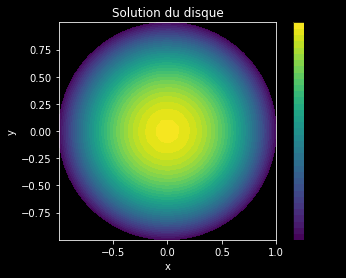

In [7]:
# Tracer la solution avec Matplotlib
plt.figure(facecolor='black')  # Fond noir
plt.gca().patch.set_facecolor('black')
plot = fe.plot(Ttrial)
plt.colorbar(plot)
plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['top'].set_color('white')
plt.gca().spines['right'].set_color('white')
plt.gca().spines['left'].set_color('white')
plt.gca().tick_params(axis='x', colors='white')
plt.gca().tick_params(axis='y', colors='white')
plt.xlabel('x', color='white')
plt.ylabel('y', color='white')
plt.title('Solution du disque', color='white')
plt.savefig('output/disque_solution_plot.png', facecolor='black')  # Spécifier le chemin du fichier PNG
plt.show()

<div style="text-align: center;">
  <figure style="display: inline-block;">
    <img src="/src/content/work/output/disque_solution_plot.png" alt="Figure 3 : Solution du champ de température au sein du disque " width="350"/>
    <figcaption>Figure 3 : Solution du champ de température au sein du disque </figcaption>
  </figure>
</div>

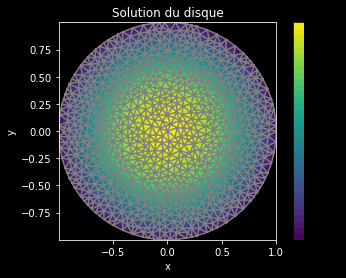

In [8]:
# Tracer la solution avec Matplotlib
plt.figure(facecolor='black')  # Fond noir
plt.gca().patch.set_facecolor('black')
plot = fe.plot(Ttrial)
plt.colorbar(plot)
plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['top'].set_color('white')
plt.gca().spines['right'].set_color('white')
plt.gca().spines['left'].set_color('white')
plt.gca().tick_params(axis='x', colors='white')
plt.gca().tick_params(axis='y', colors='white')
plt.xlabel('x', color='white')
plt.ylabel('y', color='white')
plt.title('Solution du disque', color='white')
fe.plot(mesh)
plt.savefig('output/disque_solution_plot_mesh.png', facecolor='black')  # Spécifier le chemin du fichier PNG
plt.show()

<div style="text-align: center;">
  <figure style="display: inline-block;">
    <img src="/src/content/work/output/disque_solution_plot_mesh.png" alt="Figure 4 : Solution du champ de température au sein du disque et maillage" width="350"/>
    <figcaption>Figure 4 : Solution du champ de température au sein du disque avec son maillage</figcaption>
  </figure>
</div>

<p style="text-align: justify;">
Exportons le champ solution sous la forme d'un fichier vtk nommée ThermStat.pvd et affichons le résultat à l'aide du logiciel Paraview.
</P> 

In [9]:
# Enregistrer la soluion au format VTK
vtkfile = File('output/ThermStat_adim.pvd')
vtkfile << Ttrial
# Enregistrer le maillage au format VTK
vtkfile = File('output/mesh_circle_adim.pvd')
vtkfile << mesh

### 6. Conclusion

<p style="text-align: justify;">
Ce travail nous a permis de résoudre analytiquement puis numériquement un problème de conduction thermique bidimensionnelle à l'aide des éléments finis et d'évaluer l'erreur de discrétisation.
</P> 